# Survival Analysis

If we define the time for a randomly chosen unemployed person to become employed as

$$ T\ge0 $$

Then the **Survival Function** $S(t)$ is the probability that at any given time $t$ the person remains unemployed. You could also rephrase this to say that the survival function is the probability that $t$ has not yet exceeded the employment date $T$

$$ S(t) = P ( T > t) $$

The **Hazard function** $\lambda(t)$ is the probability that the person will become employed at a particular time $t$, (or that $T$ is some minute difference away from $t$

$$ \lambda(t) = \lim_{h \to 0} \frac{P( t \leq T < t+h | T \geq t)}{h} $$

## Preparing data

We import the lifelines and pandas packages, and read in an example dataset.

This example has 177 samples, with the following variables:

* week refers to the number of weeks a person looked for work before. For the purposes of this test dataset, if a person exceeds 52 weeks of unemployment, they are assumed to remain unemployed forever.

* employed is an indicator of whether they become employed again (1) or not (0)

* wexp is the amount of work experience they had gained up to being unemployed

In [17]:
import lifelines
import pandas as pd

data = pd.read_csv('example.csv')
data

,week,employed,age,gender,wexp
0,20,1,27,Male,324
1,17,1,18,Male,162
2,25,1,19,Female,228
3,23,1,25,Male,500
4,37,1,17,Male,102
...,...,...,...,...,...
172,52,0,31,Female,1488
173,52,0,20,Male,100
174,52,0,20,Male,300
175,52,0,29,Male,406


## Estimating the Survival Function

We can estimate the Survival Function for re-employment using the Kaplan-Meier Estimate

$$ \hat{S}(t) = \prod_{t_{i}<t} ( 1 - \frac{d_{i}}{n_{i}} ) $$

where $d_{i}$ is the number of people employed at time $t$, and $n_{i}$ is the number of people that still have a chance of employment at the point just before time $t$. The estimator is a series of declining horizontal steps which, with a large enough sample size, approaches the true survival function for that population.

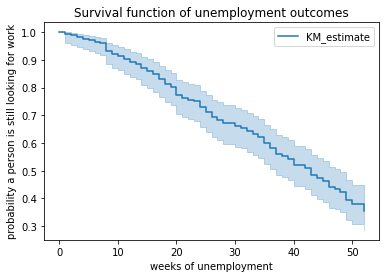

In [22]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

T = data["week"]
E = data["employed"]

kmf.fit(T, event_observed=E)

from matplotlib import pyplot as plt

kmf.plot()
plt.title('Survival function of unemployment outcomes');
plt.ylabel('probability a person is still looking for work');
plt.xlabel('weeks of unemployment');

The y-axis represents the probability a person is still unemployed after $t$ weeks, where $t$ weeks is on the x-axis. Light blue areas represent confidence intervals.

The median time in unemployment, which defines the point in time where on average 50% of the sampled population has become employed, can be read from the chart or calculated:

In [23]:
kmf.median_survival_time_

43.0

Let’s segment on gender. Calling plot on either the estimate itself or the fitter object will return an axis object, that can be used for plotting further estimates:

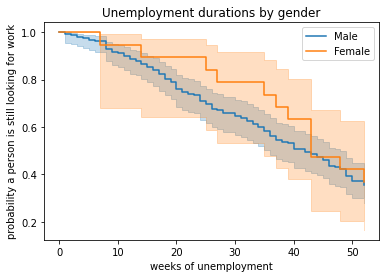

In [25]:
ax = plt.subplot(111)

gen = (data["gender"] == "Male")

kmf.fit(T[gen], event_observed=E[gen], label="Male")
kmf.plot(ax=ax)

kmf.fit(T[~gen], event_observed=E[~gen], label="Female")
kmf.plot(ax=ax)

plt.title("Unemployment durations by gender");
plt.ylabel('probability a person is still looking for work');
plt.xlabel('weeks of unemployment');

The two curves have overlapping confidence intervals so are unlikely to be significantly different. You can test whether they are different below

In [26]:
from lifelines.statistics import logrank_test

results = logrank_test(T[gen], T[~gen], E[gen], E[~gen], alpha=.99)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.25 0.62      0.69

The test statistic shows the two series are not statistically signficantly different.

You can also compare by experience level and age (below)

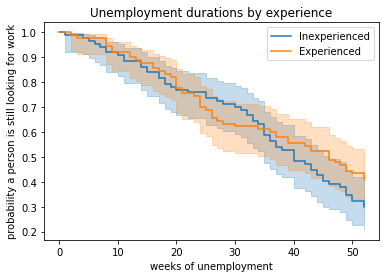

In [31]:
ax = plt.subplot(111)

gen = (data["wexp"] < 308) # the median level of experience

kmf.fit(T[gen], event_observed=E[gen], label="Inexperienced")
kmf.plot(ax=ax)

kmf.fit(T[~gen], event_observed=E[~gen], label="Experienced")
kmf.plot(ax=ax)

plt.title("Unemployment durations by experience");
plt.ylabel('probability a person is still looking for work');
plt.xlabel('weeks of unemployment');

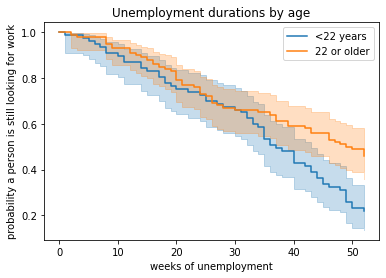

In [38]:
ax = plt.subplot(111)

gen = (data["age"] < 22) # the median age

kmf.fit(T[gen], event_observed=E[gen], label="<22 years")
kmf.plot(ax=ax)

kmf.fit(T[~gen], event_observed=E[~gen], label="22 or older")
kmf.plot(ax=ax)

plt.title("Unemployment durations by age");
plt.ylabel('probability a person is still looking for work');
plt.xlabel('weeks of unemployment');

## Survival Regression

We can try to estimate the survival function, based on the explanatory variables we have available to us (age, work experience and gender).

A standard model is Cox Proportional Hazards model. The idea behind this is that the log-hazard of an individual is a linear function of their covariates and a population-level baseline hazard that changes over time.

This assumes that an explanatory variable has a multiplicative effect on the survival function, and that it's impact is constant over time (a key assumption here).

$$ \underbrace{h(t | x)}_{\text{hazard}} = \overbrace{b_0(t)}^{\text{baseline hazard}} \underbrace{\exp \overbrace{\left(\sum_{i=1}^n b_i (x_i - \overline{x_i})\right)}^{\text{log-partial hazard}}}_ {\text{partial hazard}} $$

where $h(t | x)$ is the hazard rate we are estimating, $b_{0}(t)$ is a baseline time dependent hazard, and $x_{i}$ are the covariates (explanatory variables).

Age seems to be a factor here so we could try this as an explanatory variable in the model.


In [43]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()

cph.fit(data,
        duration_col='week',
        event_col='employed',
        formula="age")

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 177 total observations, 63 right-censored observations>
             duration col = 'week'
                event col = 'employed'
      baseline estimation = breslow
   number of observations = 177
number of events observed = 114
   partial log-likelihood = -537.37
         time fit was run = 2020-11-04 23:46:50 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age        -0.06       0.95       0.02            -0.10            -0.02                 0.91                 0.98

              z    p   -log2(p)
covariate                      
age       -2.72 0.01       7.24
---
Concordance = 0.58
Partial AIC = 1076.73
log-likelihood ratio test = 8.62 on 1 df
-log2(p) of ll-ratio test = 8.23

The coefficient interpretation here is that a one unit increase in age means that the baseline hazard will reduce by 5%. This means that a one unit increase in age results in a lower probability of employment.

The confidence intervals suggest we can be fairly assured that age is a potential explanatory factor.

After fitting, we can plot what the survival curves look like as we vary a single covariate while holding everything else equal. This is useful to understand the impact of a covariate, given the model. Lets do this with age.

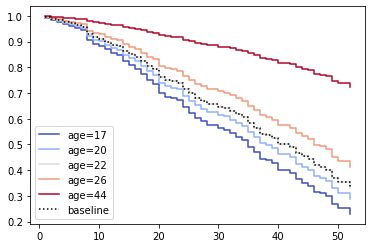

In [46]:
cph.fit(data,
        duration_col='week',
        event_col='employed',
        formula="age")

cph.plot_partial_effects_on_outcome(covariates='age',
                                    values=[17, 20, 22, 26, 44],
                                    cmap='coolwarm')

It clearly shows that older people have lower probabilities of employment relative to a baseline.

We can check our predictions against our actual values by looking at a concordance index.

This measure evaluates the accuracy of the ranking of predicted times for employment among the samples we have.

* 0.5 is the expected result from random predictions,
* 1.0 is perfect concordance and,
* 0.0 is perfect anti-concordance (multiply predictions with -1 to get 1.0)

Fitted survival models typically have a concordance index between 0.55 and 0.75

In [47]:
print(cph.concordance_index_)

0.5756734754292481


It clearly has very weak explanatory power, but some power nonetheless.